# <center>Physics-informed neural network</center>

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

#### Red neuronal

In [18]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(1 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 3)

        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
        self.apply(init_weights)
        
        # Parámetros del modelo SIR:
        self.beta = nn.Parameter(torch.rand(1))
        self.gamma = nn.Parameter(torch.rand(1))
        self.kappa = nn.Parameter(torch.rand(1))
    
    def forward(self, input):
        
        for layer in self.inner_layers:
            input = nn.Tanh()(layer(input))
        input = self.last_layer(input)
        
        return input

In [19]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

#### ODE

In [20]:
from scipy.integrate import solve_ivp
import numpy as np

def generate_data(N_data, T, X0, args, noise=0.02):
    
    def _SIR(t, X, args):
        beta, gamma, kappa = args
        s, i, r = X
        dS = - beta * s * i + kappa * r
        dI = beta * s * i - gamma * i
        dR = gamma * i - kappa * r
        return (dS, dI, dR)
    
    solution = solve_ivp(_SIR, (0, T), X0, args=(args,), rtol=10e-10, atol=10e-10, dense_output=True)['sol']
    t = torch.linspace(0, T, N_data)
    ode_solution = torch.tensor(solution(t)).permute(1, 0).float()
    noise = torch.empty(N_data, 3).normal_(noise)
    
    return (t.unsqueeze(1), ode_solution)# + noise)


In [21]:
def SIR(t, net):
    s, i, r = net(t).unsqueeze(0).permute(2, 1, 0)
    s_ode = derivative(s, t) - (- net.beta * s * i + net.kappa * r)
    i_ode = derivative(i, t) - (net.beta * s * i - net.gamma * i)
    r_ode = derivative(r, t) - (net.gamma * i - net.kappa * r)
    return (s_ode, i_ode, r_ode)


#### Entrenamiento

In [22]:
net = NeuralNetwork(n_layers=2, wide=20)
optimizer = torch.optim.Adam(net.parameters())

In [23]:
T = 5
samples_data, samples_phys = 200, 100

epochs = 10000
weights = (0.5, 0.2, 0.3)

initial_conditions = (0.9, 0.1, 0)
args = (4, 1, 0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Data conocida (fija):
t_data, target_data = generate_data(samples_data, 10, initial_conditions, args)
try:
    loss_record = []
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        
        # Data conocida:
        s_data, i_data, r_data = net(t_data).unsqueeze(0).permute(2, 1, 0)
        output_data = torch.cat((s_data, i_data, r_data), dim=1)
        loss_data = nn.MSELoss()(output_data, target_data)
        
        # Condición inicial:
        t_initial = torch.zeros(1, 1)
        s_initial, i_initial, r_initial = net(t_initial).unsqueeze(0).permute(2, 1, 0)
        output_initial = torch.cat((s_initial, i_initial, r_initial), dim=1)
        target_initial = torch.tensor(initial_conditions).expand_as(output_initial)
        loss_initial = nn.MSELoss()(output_initial, target_initial)
        
        # Modelo:
        t_phys = torch.empty(samples_phys, 1, device=device).uniform_(to=T).requires_grad_()
        output_phys = torch.cat(SIR(t_phys, net), dim=1)
        target_phys = torch.zeros(samples_phys, 3, device=device)
        loss_phys = nn.MSELoss()(output_phys, target_phys)

        # Optimización:
        loss = weights[0] * loss_data + weights[1] * loss_phys + weights[2] * loss_initial
        loss_record.append(loss.item())
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch} || loss: {loss:.4f}')
            
except KeyboardInterrupt:
    pass

Epoch 1000 || loss: 0.0037
Epoch 2000 || loss: 0.0017
Epoch 3000 || loss: 0.0010
Epoch 4000 || loss: 0.0004
Epoch 5000 || loss: 0.0002
Epoch 6000 || loss: 0.0001
Epoch 7000 || loss: 0.0000
Epoch 8000 || loss: 0.0000
Epoch 9000 || loss: 0.0000
Epoch 10000 || loss: 0.0000


#### Simulación y comparación con la solución real

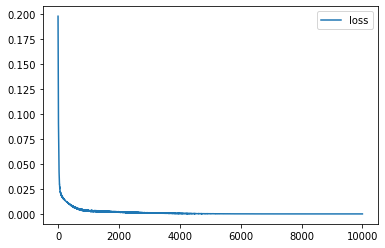

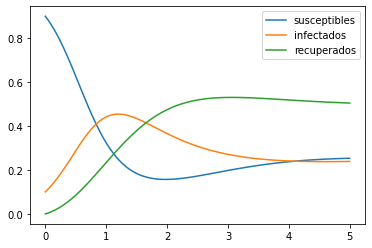

Beta: 3.9872
Gamma: 0.9973
Kappa: 0.4976


In [24]:
net.to('cpu')
net.eval()

# Entrenamiento:
plt.plot(torch.arange(1, len(loss_record) + 1), loss_record, label='loss')
plt.legend()
plt.show()

# Simulación:

t = torch.linspace(0, T, 100).unsqueeze(1)
s, i, r = net(t).unsqueeze(0).permute(2, 1, 0).detach()

values = {'susceptibles': s,
          'infectados': i,
          'recuperados': r}

for f in ('susceptibles', 'infectados', 'recuperados'):
    plt.plot(t, values[f], label=f)
plt.legend()
plt.show()

# Parámetros:
print(f'Beta: {net.beta.item():.4f}')
print(f'Gamma: {net.gamma.item():.4f}')
print(f'Kappa: {net.kappa.item():.4f}')
